In [13]:
import pandas as pd
import ezodf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import pandas_profiling as pp
import pycaret
from pycaret.regression import *
from pycaret.regression import RegressionExperiment
from IPython.display import clear_output
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, Normalizer, 
    MaxAbsScaler, QuantileTransformer, PowerTransformer
)
from sklearn.feature_selection import SequentialFeatureSelector
from catboost import CatBoostRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV
from sklearn.cluster import KMeans

In [14]:
seed = 17

# Read file

In [15]:
def read_ods(filename, sheet_no=0, header=0):
    tab = ezodf.opendoc(filename=filename).sheets[sheet_no]
    return pd.DataFrame({col[header].value:[x.value for x in col[header+1:]]
                        for col in tab.columns()})

In [16]:
tbtl = read_ods('./Data/label/tbtl-public.ods')
ck = pd.read_csv('./Data/ready_data/ready_ck.csv')
qt = pd.read_csv('./Data/ready_data/ready_qt.csv')

tbtl.TBTL = tbtl.TBTL.astype(float)

In [17]:
ck = ck[['username', 'CK']]
qt = qt[['username', 'diemqt']]

In [18]:
df = pd.read_csv('./Data/ready_data/ready_th.csv')

In [19]:
df.columns

Index(['username', 'count_submit', 'count_problem', 'avg_submit',
       'count_assignment', 'sum_pre_score', 'avg_pre_score', 'avg_coef',
       'time', 'ratio', 'point_hard', 'time_hard', 'avg_submit_hard', 'start',
       'max_problem', 'count_hard_problems', 'ratio_problem', 'hash', 'TH'],
      dtype='object')

In [20]:
df.drop(columns=['hash'], inplace=True)

In [21]:
df = pd.merge(df, ck, on='username', how='left')
df = pd.merge(df, qt, on='username', how='left')
df = pd.merge(df, tbtl, on='username', how='left')

# QT

In [22]:
qt_df = df.drop(columns=['TH', 'CK', 'TBTL'])

In [23]:
def experiment(df, id='username', target='TH', dev=False, seed=17):
    df.dropna(inplace=True)
    results = []

    scalers = {
        'StandardScaler': StandardScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'RobustScaler': RobustScaler(),
        'Normalizer': Normalizer(),
        'MaxAbsScaler': MaxAbsScaler(),
        'QuantileTransformer': QuantileTransformer(),
        'PowerTransformer': PowerTransformer(method='yeo-johnson')
    }

    for scaler_name, scaler in scalers.items():
        df_scaled = df.copy()

        # Apply the scaler to all columns except the target and id
        if id in df_scaled.columns and target in df_scaled.columns:
            features = df_scaled.drop(columns=[id, target]).columns
        elif id in df_scaled.columns:
            features = df_scaled.drop(columns=[id]).columns
        elif target in df_scaled.columns:
            features = df_scaled.drop(columns=[target]).columns
        else:
            features = df_scaled.columns
        
        df_scaled[features] = scaler.fit_transform(df_scaled[features])
        df_scaled[target] = df[target]

        # Run the model training and evaluation
        s = setup(data=df_scaled.drop(columns=[id]), target=target, use_gpu=True, profile=False, session_id=seed)
        clear_output()
        best_model = compare_models(fold=5, sort='R2', verbose=False)
        result = pull()
        result = result[['Model', 'R2']]
        result = result[result['R2'] > 0.2]
        if dev:
            result = result.head(1)
        result['Scaler'] = scaler_name
        results.append(result)

    # Combine results from all scalers into a single DataFrame
    final_results = pd.concat(results, ignore_index=True)
    return final_results

In [24]:
exclude_list = ['par', 'dt', 'huber', 'dummy', 'knn', 'omp', 'ada', 'lar']

# inital result

In [25]:
# s = setup(data = qt_df.drop(columns=['username']), target = 'diemqt', use_gpu=True, profile=False, session_id=seed)
# clear_output()
# best_model = compare_models(fold=5, sort='R2', exclude=exclude_list)

# EDA

In [26]:
# pp.ProfileReport(qt_df)

In [27]:
def draw_scatter_plot(x, y, df=qt_df, x_threshold=None, y_threshold=None):
    def categorize_diemqt(diemqt):
        if diemqt < 5:
            return 'diemqt < 5'
        elif 5 <= diemqt < 8:
            return '5 < diemqt < 8'
        elif 8 <= diemqt <= 10:
            return '8 < diemqt < 10'
        else:
            return 'Other'  # To handle TH values outside the specified ranges
        
    df['diemqt_category'] = df['diemqt'].apply(categorize_diemqt)
    sns.scatterplot(data=df, x=x, y=y, hue='diemqt_category')
    if x_threshold is not None:
        plt.axvline(x=x_threshold, color='red', linestyle='--', linewidth=2)
    if y_threshold is not None:
        plt.axhline(y=y_threshold, color='red', linestyle='--', linewidth=2)

### point hard vs time

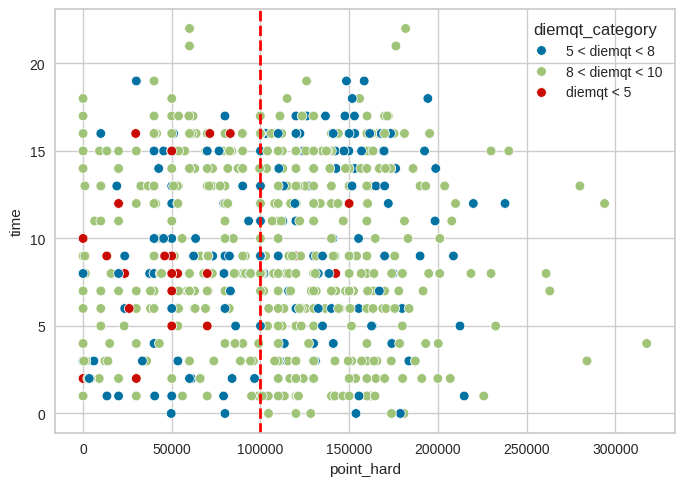

In [28]:
draw_scatter_plot('point_hard', 'time', x_threshold=100000)

### count problem vs avg submit

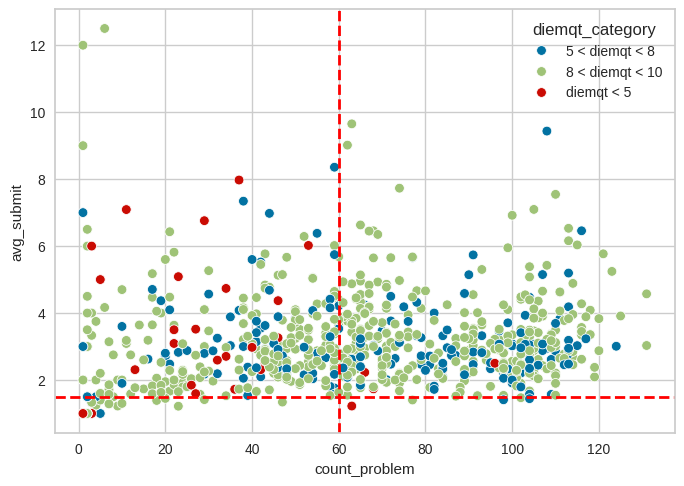

In [36]:
draw_scatter_plot('count_problem', 'avg_submit', x_threshold=60, y_threshold=1.5)

### count problem vs avg coef

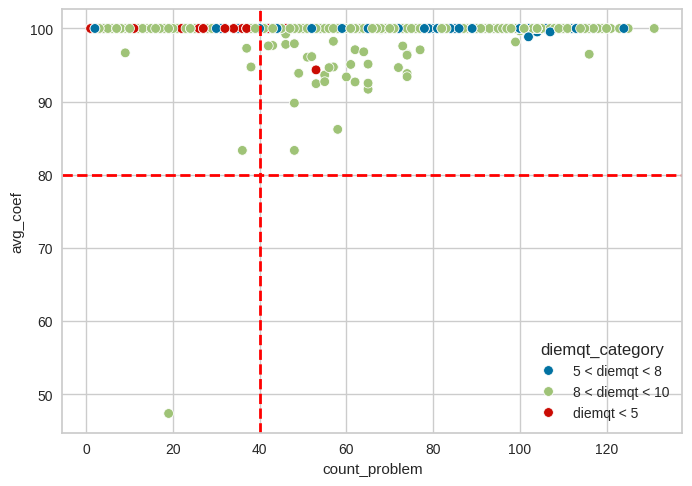

In [37]:
draw_scatter_plot('count_problem', 'avg_coef', x_threshold=40, y_threshold=80)

### count problem

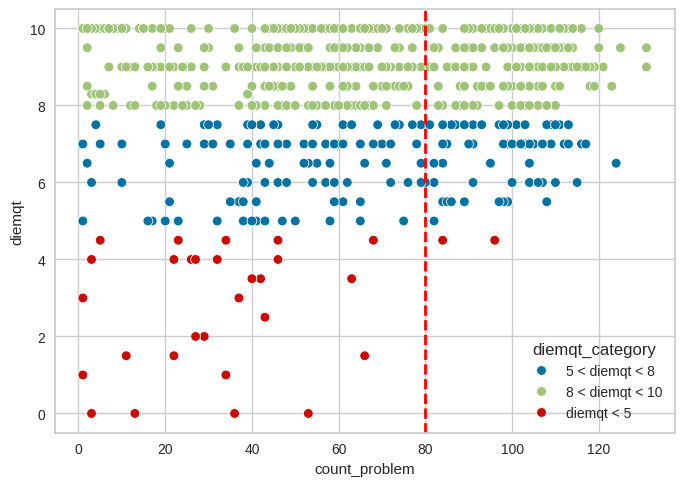

In [31]:
draw_scatter_plot('count_problem', 'diemqt', x_threshold=80)

### count assignment

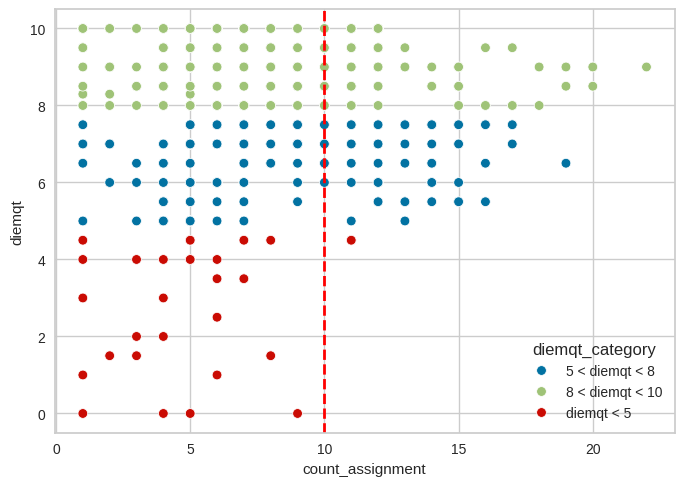

In [32]:
draw_scatter_plot('count_assignment', 'diemqt', x_threshold=10)

### max problem

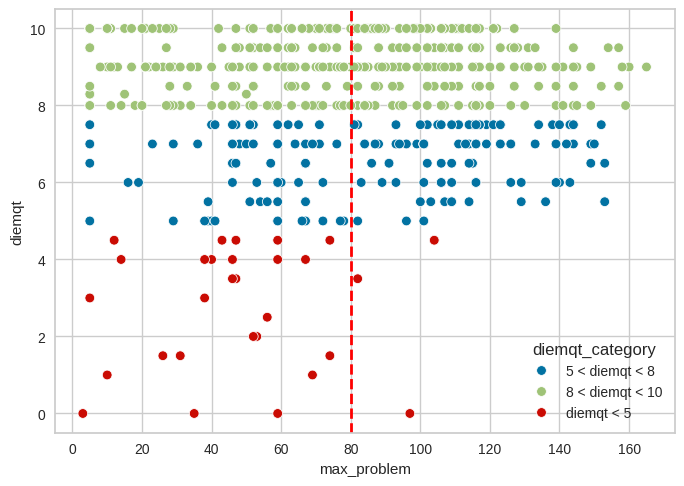

In [33]:
draw_scatter_plot('max_problem', 'diemqt', x_threshold=80)

### count hard problem

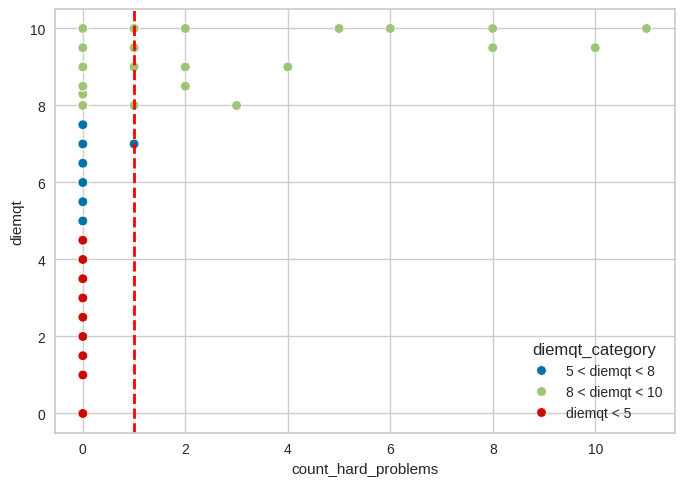

In [34]:
draw_scatter_plot('count_hard_problems', 'diemqt', x_threshold=1)

In [38]:
def qt_preprocess(df):
    df_copy = df.copy()
    df_copy['over_100000_point_hard'] = df_copy['point_hard'] >= 100000
    df_copy['over_60_count_problem_over_1.5_avg_submit'] = (df_copy['count_problem'] >= 60) & (df_copy['avg_submit'] >= 1.5)
    df_copy['over_40_count_problem_over_80_avg_coef'] = (df_copy['count_problem'] >= 40) & (df_copy['avg_coef'] > 80)
    df_copy['over_80_count_problem'] = df_copy['count_problem'] >= 80
    df_copy['over_10_count_assignment'] = df_copy['count_assignment'] >= 10
    df_copy['over_80_max_problem'] = df_copy['max_problem'] >= 80
    df_copy['over_1_count_hard_problems'] = df_copy['count_hard_problems'] >= 1
    
    return df_copy

In [40]:
if 'diemqt_category' in qt_df.columns:
    qt_df.drop(columns=['diemqt_category'], inplace=True)

In [41]:
train_df = qt_preprocess(qt_df)
len(train_df.columns), len(qt_df.columns)

(25, 18)

In [42]:
s = setup(data=train_df.drop(columns=['username']), target='diemqt', use_gpu=True, profile=False, session_id=seed)
clear_output()
best_model = compare_models(fold=5, sort='R2', exclude=exclude_list)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1.1147,2.3719,1.5250,0.1312,0.2198,0.1666,0.1220
catboost,CatBoost Regressor,1.1180,2.3870,1.5291,0.1272,0.2211,0.1687,5.4320
et,Extra Trees Regressor,1.1118,2.4235,1.5432,0.1070,0.2214,0.1657,0.0800
lightgbm,Light Gradient Boosting Machine,1.1091,2.4704,1.5567,0.0955,0.2240,0.1668,5.9520
gbr,Gradient Boosting Regressor,1.1360,2.5096,1.5697,0.0792,0.2262,0.1720,0.1220
en,Elastic Net,1.2657,2.7873,1.6525,-0.0122,0.2360,0.1957,0.0180
lasso,Lasso Regression,1.2692,2.7905,1.6536,-0.0137,0.2361,0.1962,0.0180
llar,Lasso Least Angle Regression,1.2692,2.7905,1.6536,-0.0137,0.2361,0.1962,0.0140
br,Bayesian Ridge,1.2928,2.8593,1.6752,-0.0417,0.2383,0.1993,0.0200
ridge,Ridge Regression,1.2896,2.9037,1.6932,-0.0741,0.2376,0.1952,0.0140


# Feature selection

In [43]:
selector = RFECV(estimator=CatBoostRegressor(random_seed=seed, verbose=False),
                 cv=5, scoring='r2', n_jobs=-1)

In [44]:
selector.fit(train_df.drop(columns=['username', 'diemqt']), train_df['diemqt'])

RFECV(cv=5,
      estimator=<catboost.core.CatBoostRegressor object at 0x7a22941e1240>,
      n_jobs=-1, scoring='r2')

In [ ]:
np.save('Data/qt_selector.npy')

In [ ]:
selector_support = np.load('Data/qt_selector.npy')

In [45]:
selected_features = train_df.drop(columns=['username', 'diemqt']).columns[selector.support_]

In [53]:
df_train = train_df[['username', 'diemqt'] + list(selected_features)]

# Pipeline

In [54]:
def qt_preprocessing(df_train, df_test):
    
    train = qt_preprocess(df_train)
    test = qt_preprocess(df_test)
    
    selector_support = np.load('Data/qt_selector.npy')
    train = train[['username', 'diemqt'] + list(train.drop(columns=['diemqt', 'username']).columns[selector_support])]
    test = test[['username'] + list(test.drop(columns=['username']).columns[selector_support])]
    
    scaler = Normalizer()
    features = train.drop(columns=['username', 'diemqt']).columns
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])
    
    return train, test

In [55]:
test = pd.read_csv('./Data/work_data.csv')
test = test[~test.username.isin(qt_df.username)]

In [58]:
df_train, df_test = qt_preprocessing(qt_df, test)

## modelling

In [59]:
s = setup(data = df_train.drop(columns=['username']), target = 'diemqt', use_gpu=True, profile=False, session_id=seed)
clear_output()
top5 = compare_models(fold=5, sort='R2', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1.1549,2.5477,1.5803,0.0726,0.2279,0.1787,0.1060
catboost,CatBoost Regressor,1.1416,2.6254,1.5994,0.0557,0.2296,0.1779,4.7240
et,Extra Trees Regressor,1.1452,2.6227,1.6054,0.0380,0.2301,0.1764,0.0860
gbr,Gradient Boosting Regressor,1.1775,2.6532,1.6134,0.0311,0.2304,0.1820,0.0940
lightgbm,Light Gradient Boosting Machine,1.2085,2.8158,1.6573,-0.0184,0.2344,0.1857,1.4420
lasso,Lasso Regression,1.2893,2.8386,1.6660,-0.0256,0.2378,0.1998,0.0080
dummy,Dummy Regressor,1.2893,2.8386,1.6660,-0.0256,0.2378,0.1998,0.0060
llar,Lasso Least Angle Regression,1.2893,2.8386,1.6660,-0.0256,0.2378,0.1998,0.0060
en,Elastic Net,1.2893,2.8386,1.6660,-0.0256,0.2378,0.1998,0.0060
omp,Orthogonal Matching Pursuit,1.2915,2.8589,1.6717,-0.0324,0.2386,0.2004,0.0060


In [ ]:
tuned_top5 = [tune_model(model, fold=5, n_iter=100, 
                         optimize='MAE', search_library='optuna', choose_better=True) for model in top5]

In [ ]:
blender = blend_models(estimator_list=tuned_top5, fold=5)

In [ ]:
stacker = stack_models(estimator_list=tuned_top5, fold=5)

In [ ]:
save_model(stacker, './model/QT/stacker')
save_model(blender, './model/QT/blender')

In [60]:
stacker = load_model('./model/QT/stacker')
blender = load_model('./model/QT/blender')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [61]:
from sklearn import set_config
set_config(display='diagram')
stacker

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['avg_submit', 'count_assignment',
                                             'avg_pre_score', 'ratio',
                                             'point_hard', 'avg_submit_hard',
                                             'start', 'max_problem',
                                             'ratio_problem'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='...
                                                LGBMRegressor(bagging_fraction=0.8793591532910162,
                                                              bagging_freq=1,
                                                              device='gpu',
                                                              feature_fraction=0.7625487977593226,
                                                              learning_rate=0.01585257035131843,
                                                              min_child_samples=9,
                                                              min_split_gain=0.6451328772159026,
                                                              n_estimators=235,
                                                              n_jobs=-1,
                                                              num_leaves=56,
                                                              random_state=17,
                                                              reg_alpha=2.7146962397627576,
                                                              reg_lambda=0.0004736623402438053))],
                                   final_estimator=LinearRegression(n_jobs=-1),
                                   n_jobs=1))])

In [62]:
blender

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['avg_submit', 'count_assignment',
                                             'avg_pre_score', 'ratio',
                                             'point_hard', 'avg_submit_hard',
                                             'start', 'max_problem',
                                             'ratio_problem'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='...
                                             ('Light Gradient Boosting Machine',
                                              LGBMRegressor(bagging_fraction=0.8793591532910162,
                                                            bagging_freq=1,
                                                            device='gpu',
                                                            feature_fraction=0.7625487977593226,
                                                            learning_rate=0.01585257035131843,
                                                            min_child_samples=9,
                                                            min_split_gain=0.6451328772159026,
                                                            n_estimators=235,
                                                            n_jobs=-1,
                                                            num_leaves=56,
                                                            random_state=17,
                                                            reg_alpha=2.7146962397627576,
                                                            reg_lambda=0.0004736623402438053))],
                                 n_jobs=1))])

In [63]:
predict = predict_model(stacker, data=df_test.drop(columns=['username']))

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7625487977593226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7625487977593226
[LightGBM] [Warning] bagging_fraction is set=0.8793591532910162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8793591532910162


In [64]:
submit = pd.DataFrame({'username': test.username, 'TH': predict.prediction_label})
submit.to_csv('./qt_submit.csv', index=False, header=False)